In [3]:
import graphix 
import numpy as np
from graphix import Circuit
import networkx as nx
import matplotlib.pyplot as plt
from graphix.gflow import flow 
from graphix.pattern import *
from graphix.helper_funtions import *

In [2]:
from qiskit.circuit import Parameter, ParameterExpression

In [14]:
def process_layer_data(graph: nx.Graph, layer_map: dict):

    node_attributes = {}; max_l = max(set(layer_map.values()))
    layer_data = {n: set() for n in range(max_l +1 )}

    for v in graph.nodes():
        # print(v); print(layer_data[v])
        node_attributes[v] = {"layer" : layer_map[v]}
        layer_data[layer_map[v]].add(v)

    return {'attribute_data' : node_attributes, 'nodes_in_layers': layer_data, 'num_layers' : max_l  }


def get_nx_graph(pattern: graphix.Pattern):
    nodes, edges = pattern.get_graph()
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)

    return g

def get_pos(pattern: graphix.Pattern, f):

    num_output_nodes = len(pattern.output_nodes)
    flow = [[i] for i in range(num_output_nodes)]
    for i in range(num_output_nodes):
        contd = True
        val = i
        while contd:
            try:
                val = f[val]
                flow[i].append(val)
            except KeyError:
                contd = False
    longest = np.max([len(flow[i]) for i in range(num_output_nodes)])

    pos = dict()
    for i in range(num_output_nodes):
        length = len(flow[i])
        fac = longest / (length - 1)
        for j in range(len(flow[i])):
            pos[flow[i][j]] = (fac * j, -i)
    
    return pos, longest

# determine wheher or not a node will be measured in Pauli basis
def get_clr_list(pattern):
    nodes, edges = pattern.get_graph()
    meas_list = pattern.get_measurement_commands()
    g = get_nx_graph(pattern)
    clr_list = []
    for i in g.nodes:
        for cmd in meas_list:
            if cmd[1] == i:
                if cmd[3] in [-1, -0.5, 0, 0.5, 1]:
                    clr_list.append([0.5, 0.5, 0.5])
                else:
                    clr_list.append([1, 1, 1])
        if i in pattern.output_nodes:
            clr_list.append([0.8, 0.8, 0.8])
    return clr_list

def pretty_plot_pattern(pattern: graphix.Pattern, input_nodes : set):

    clr_list = get_clr_list(pattern)
    g = get_nx_graph(pattern)
    f, l_k = flow(g, input_nodes, set(pattern.output_nodes))
    pos, length = get_pos(pattern, f) ; layer_data = process_layer_data(g, l_k)
    
    nx.set_node_attributes(g, layer_data['attribute_data'])

    graph_params = {"with_labels": True, "node_size": 600, "node_color": get_clr_list(pattern), "edgecolors": "k"}
    pos = nx.multipartite_layout(g, subset_key= 'layer', align='vertical', scale= 100)

    plt.figure(figsize=(25,16))

    for layer in range(layer_data['num_layers']):   
        vertx_1 = next(iter(layer_data['nodes_in_layers'][layer])); xcoord_1 = pos[vertx_1][0]
        vertx_2 = next(iter(layer_data['nodes_in_layers'][layer + 1])); xcoord_2 = pos[vertx_2][0]
        xcoord = np.mean([xcoord_1, xcoord_2])
        plt.axvline(xcoord)
        plt.text(x= xcoord + 1.5, y= -18, s= 'l= ' + str(layer) )

    edge_color= []
    for u,v in g.edges():
        if( u not in pattern.output_nodes and v not in pattern.output_nodes ) :
            # print (u,v, u==f[v] or v== f[u])
            if u==f[v] or v== f[u] :
                edge_color.append('r')
            else :
                edge_color.append('g')


    nx.draw_networkx(g, pos= pos, **graph_params, edge_color = edge_color)

    
    

            

In [5]:
c = Circuit(2)
c.rzz(0,1, np.pi/ 4)
p = c.transpile(opt= True)
p.print_pattern()

N, node = 0
N, node = 1
N, node = 2
E, nodes = (0, 2)
E, nodes = (1, 2)
M, node = 2, plane = XY, angle(pi) = -0.25, s-domain = [], t_domain = [], Clifford index = 6
Z byproduct, node = 0, domain = [2]
Z byproduct, node = 1, domain = [2]


/tmp/ipykernel_4741/2538968131.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  fac = longest / (length - 1)
/tmp/ipykernel_4741/2538968131.py:42: RuntimeWarning: invalid value encountered in scalar multiply
  pos[flow[i][j]] = (fac * j, -i)


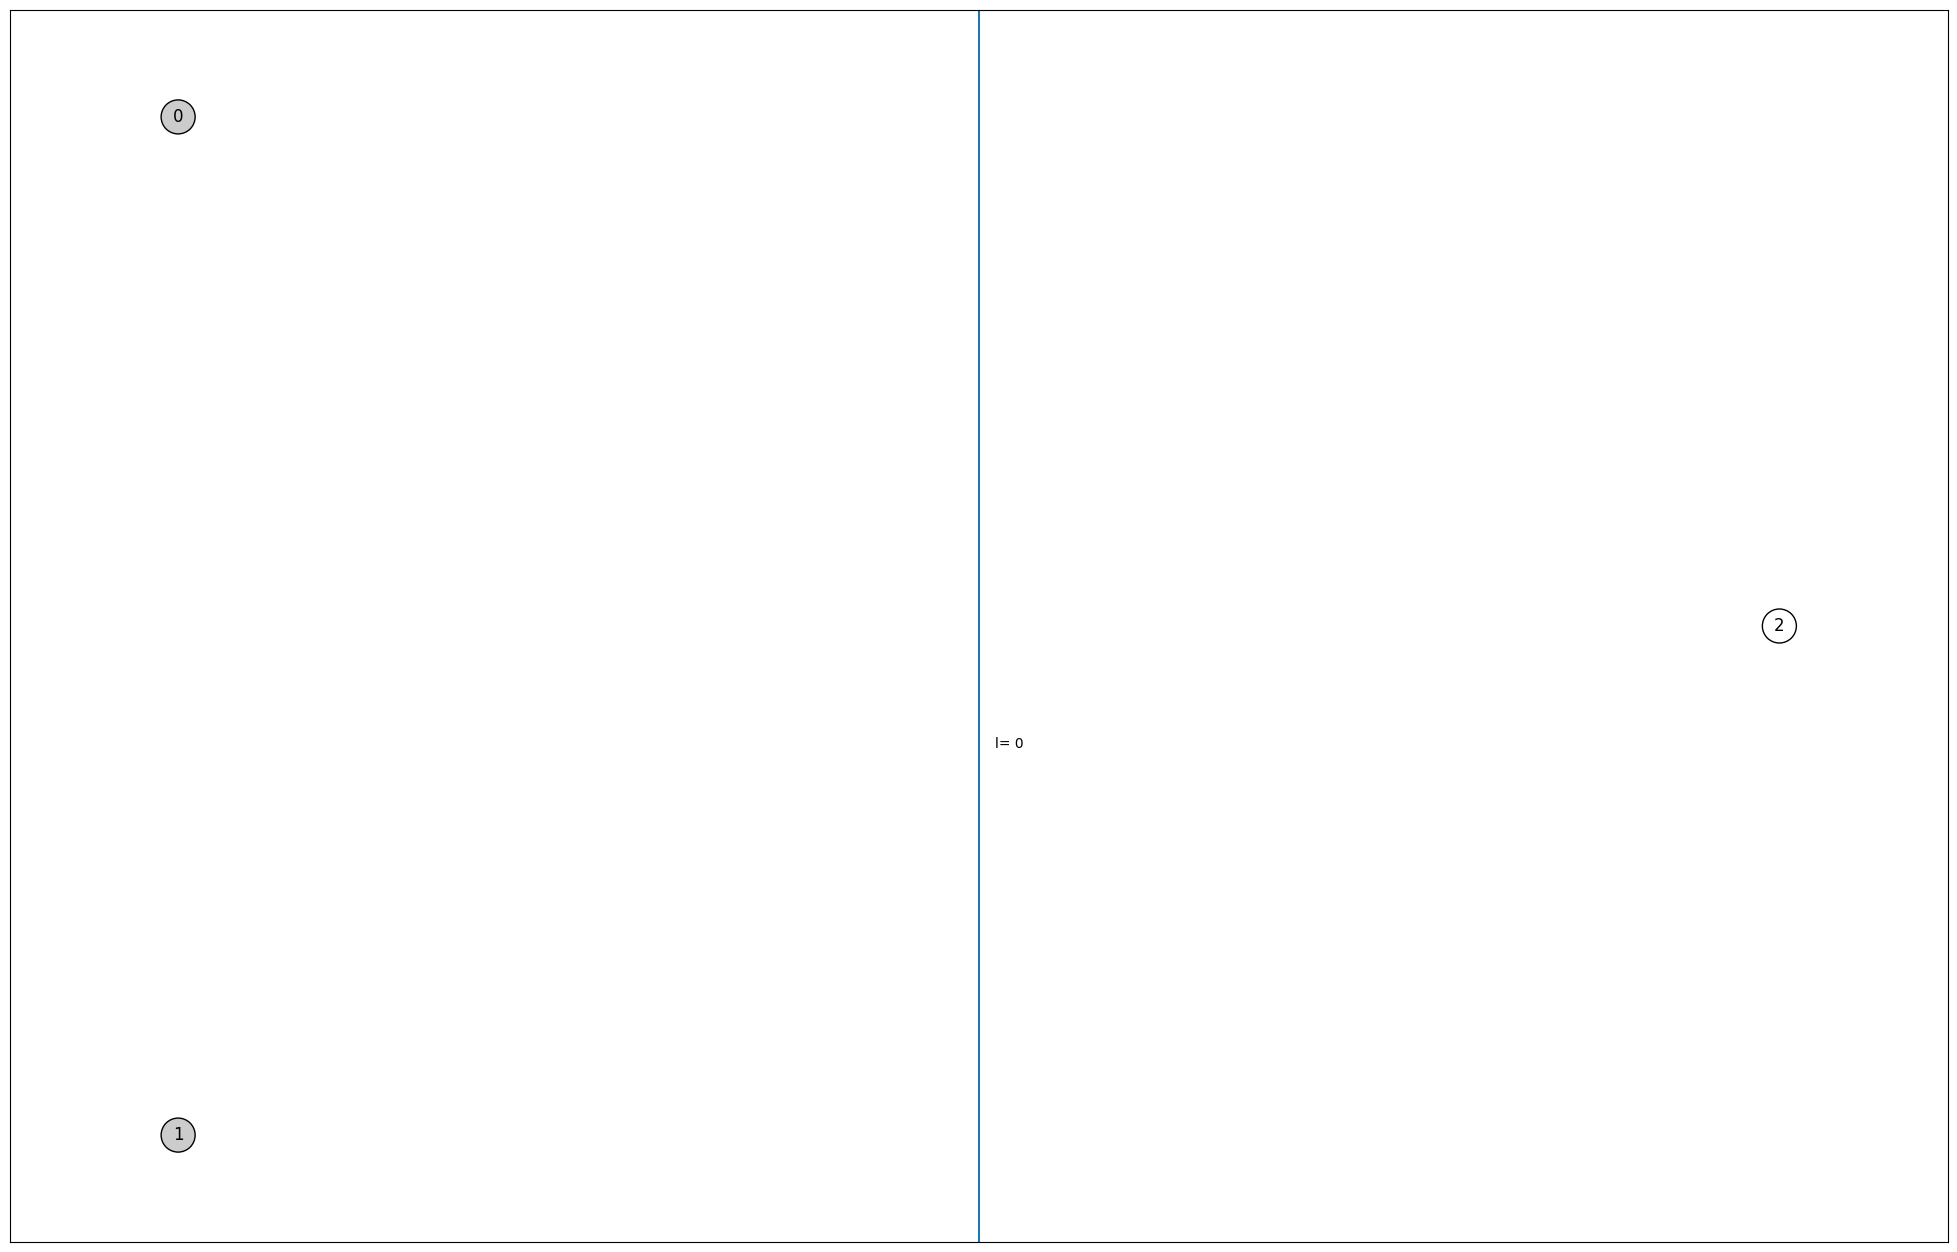

In [5]:
pretty_plot_pattern(p, {0})

##### Random Graph

In [6]:
th = Parameter('theta')

In [7]:
grp = nx.Graph()

grp.add_nodes_from([1,2,3,4])
grp.add_edges_from([(2,3), (2,4), (1,3) ])

outputs = [3,4] ; inputs= [1,2]
mangles = {1: th , 2: 0.3 * th}


In [8]:
pattrn = graphix.generate_from_graph(grp, mangles, inputs, outputs)
pattrn.standardize()

In [9]:
pattrn.print_pattern()

N, node = 1
N, node = 2
N, node = 3
N, node = 4
E, nodes = (1, 3)
E, nodes = (2, 3)
E, nodes = (2, 4)
M, node = 1, plane = XY, angle(pi) = theta, s-domain = [], t_domain = []
M, node = 2, plane = XY, angle(pi) = 0.3*theta, s-domain = [], t_domain = [1]
X byproduct, node = 3, domain = [1]
X byproduct, node = 4, domain = [2]


In [17]:
measure_pauli(pattrn)

In [16]:
pauli_nodes(pattrn)

([],
 [['M', 1, 'XY', Parameter(theta), [], []],
  ['M', 2, 'XY', ParameterExpression(0.3*theta), [], [1]]])

In [23]:
pattrn.correction_commands()

[['X', 3, [1]], ['X', 4, [2]]]

In [23]:
pattrn.get_measurement_commands()

[['M', 1, 'XY', Parameter(theta), [], []],
 ['M', 2, 'XY', ParameterExpression(0.3*theta), [], [1]]]

In [13]:
flow(grp, set(inputs), set(outputs))

({2: 4, 1: 3}, {1: 2, 2: 1, 3: 0, 4: 0})

In [22]:
isinstance(np.pi, float)

True

/tmp/ipykernel_108076/2538968131.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  fac = longest / (length - 1)
/tmp/ipykernel_108076/2538968131.py:42: RuntimeWarning: invalid value encountered in scalar multiply
  pos[flow[i][j]] = (fac * j, -i)


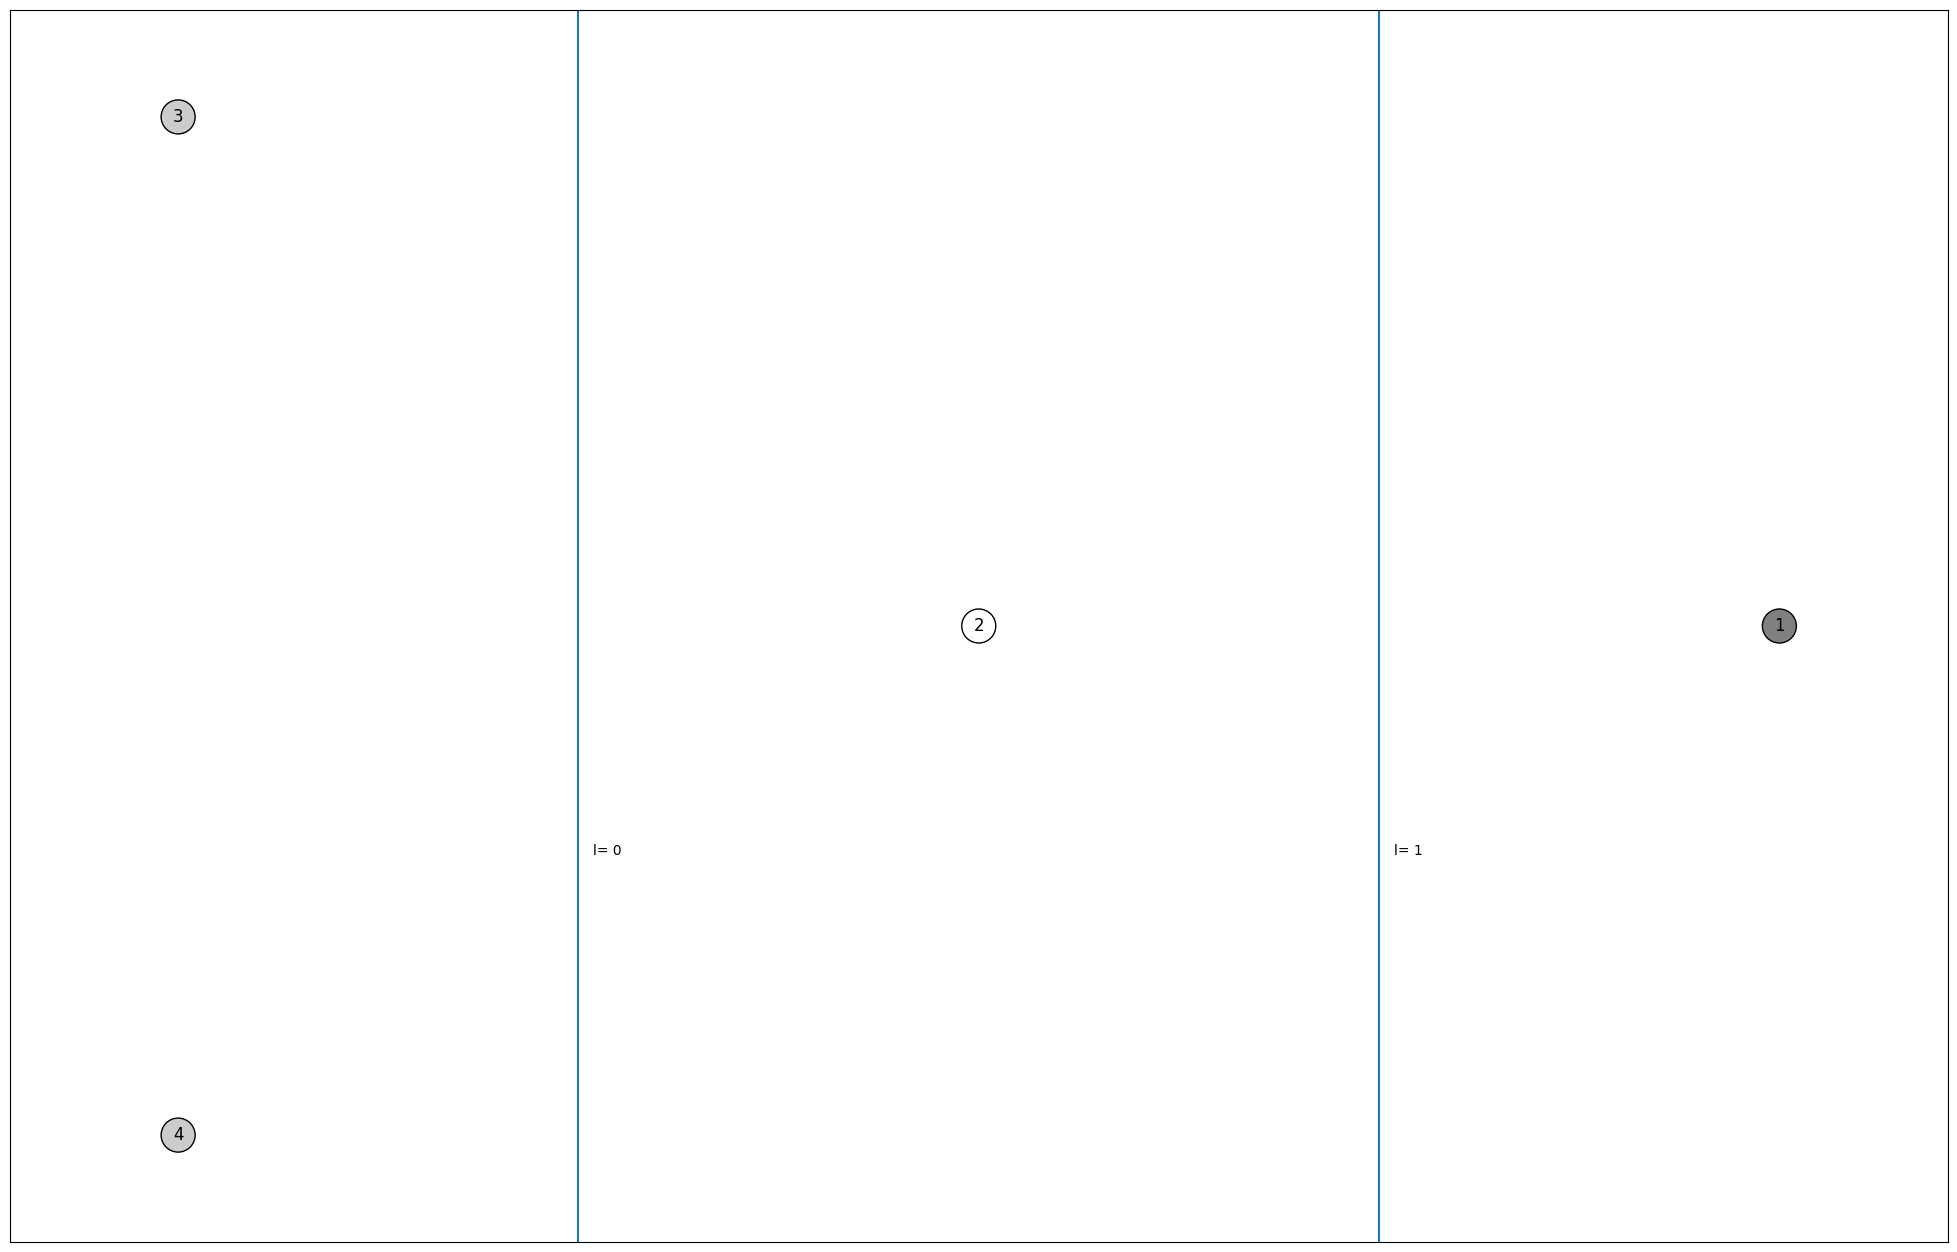

In [7]:
pretty_plot_pattern(pattern= pattrn, input_nodes= set(inputs))

##### QAOA

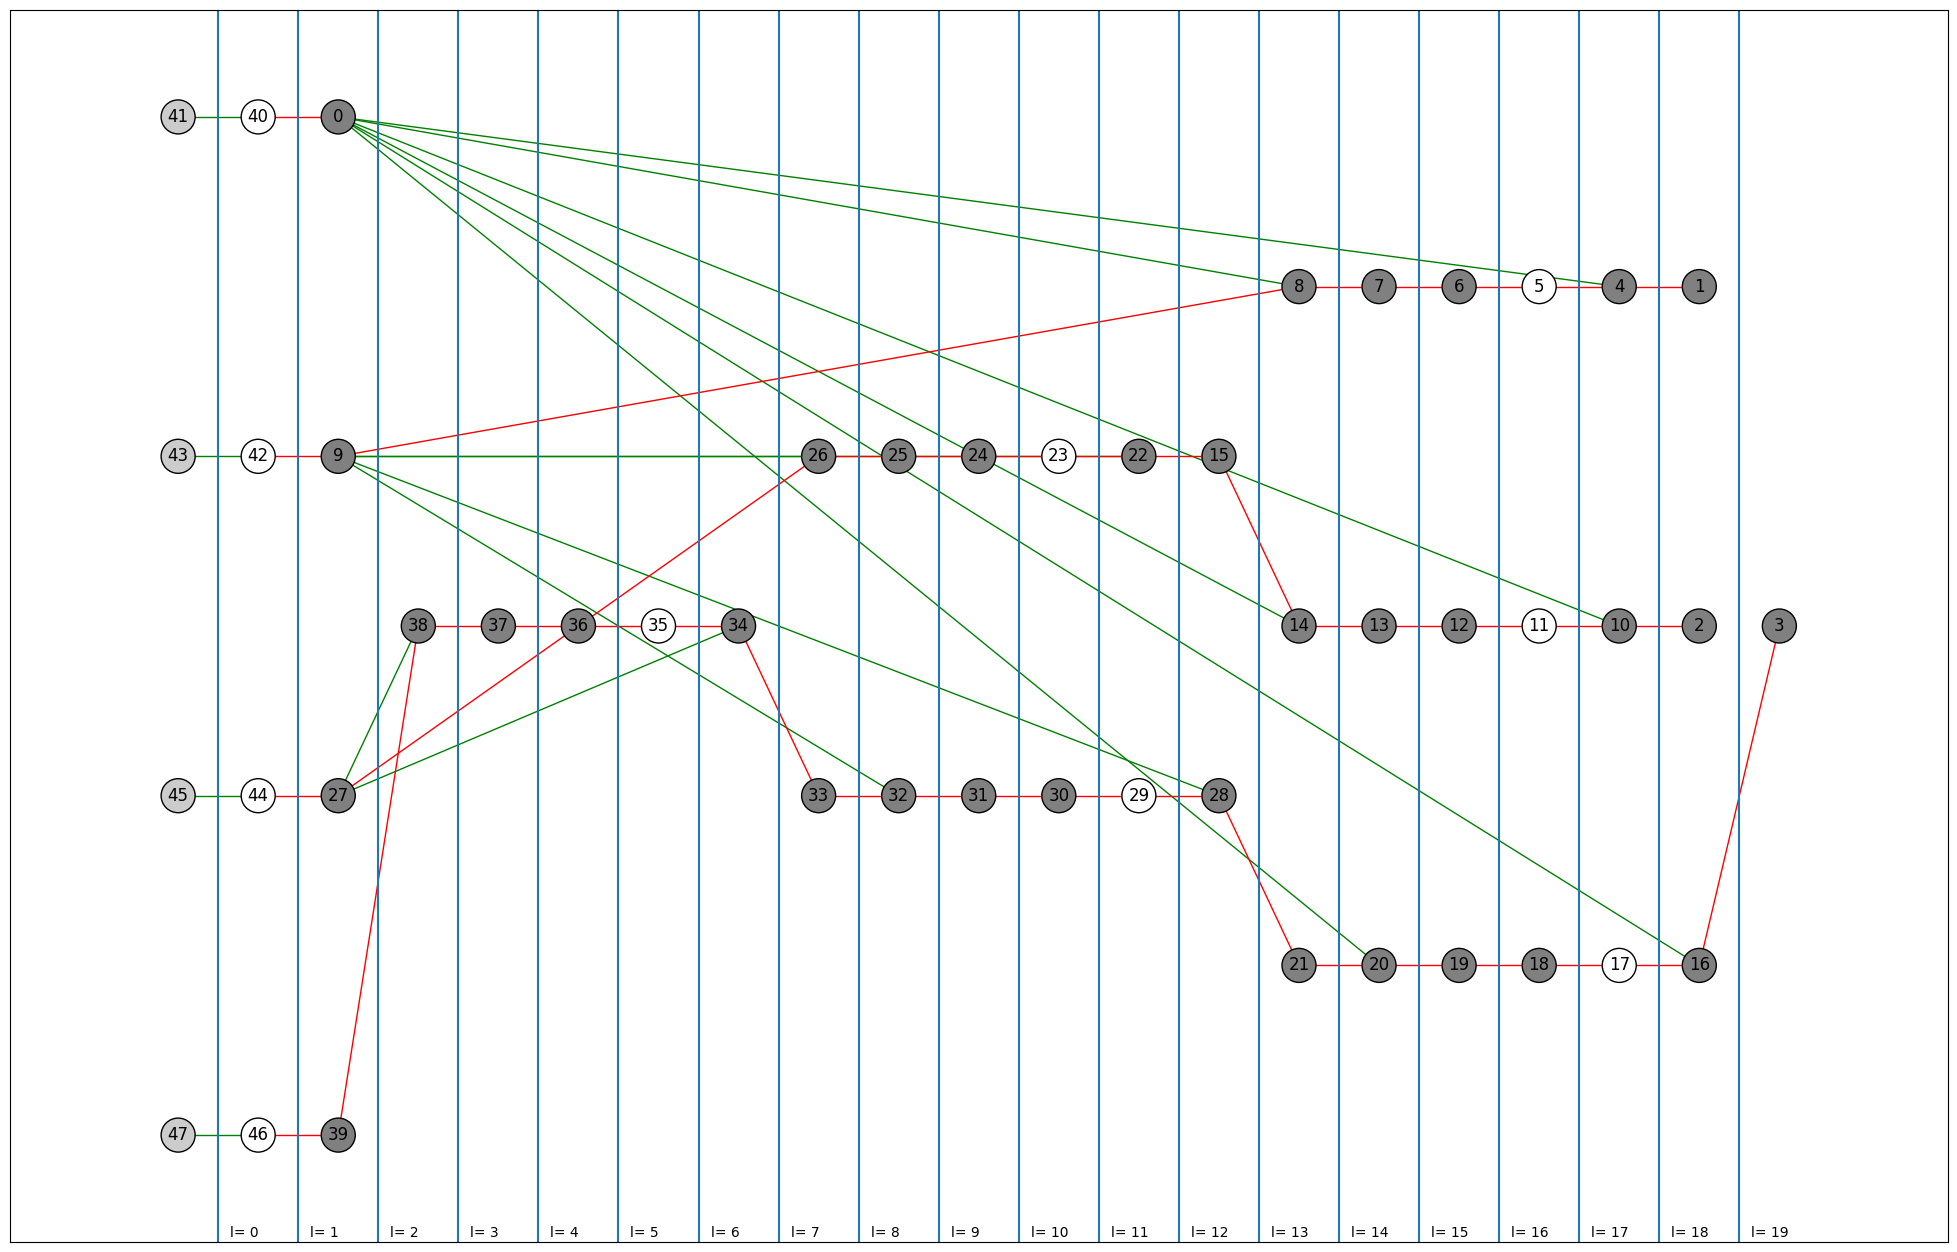

In [7]:
n = 4
xi = np.random.rand(6)
theta = np.random.rand(4)
g = nx.complete_graph(n)
circuit = Circuit(n)
for i, (u, v) in enumerate(g.edges):
    circuit.cnot(u, v)
    circuit.rz(v, xi[i])
    circuit.cnot(u, v)
for v in g.nodes:
    circuit.rx(v, theta[v])

#%%
# transpile and get the graph state

pattern = circuit.transpile()
pattern.standardize()
pattern.shift_signals()
nodes, edges = pattern.get_graph()
g = get_nx_graph(pattern)
correction_map, layer_map = flow(g, {0, 1, 2, 3}, set(pattern.output_nodes))

pretty_plot_pattern(pattern, {0, 1, 2, 3})

In [ ]:
l_k

In [8]:
layer_map

{0: 2,
 1: 19,
 2: 19,
 3: 20,
 4: 18,
 5: 17,
 6: 16,
 7: 15,
 8: 14,
 9: 2,
 10: 18,
 11: 17,
 12: 16,
 13: 15,
 14: 14,
 15: 13,
 16: 19,
 17: 18,
 18: 17,
 19: 16,
 20: 15,
 21: 14,
 22: 12,
 23: 11,
 24: 10,
 25: 9,
 26: 8,
 27: 2,
 28: 13,
 29: 12,
 30: 11,
 31: 10,
 32: 9,
 33: 8,
 34: 7,
 35: 6,
 36: 5,
 37: 4,
 38: 3,
 39: 2,
 40: 1,
 41: 0,
 42: 1,
 43: 0,
 44: 1,
 45: 0,
 46: 1,
 47: 0}

In [ ]:
pattern.simulate_pattern(backend= 'tensornetwork')